In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

os.chdir("/Users/jacobrichards/Desktop/DS_DA_Projects/3-90+_DaysPastDue/data")

train = pd.read_csv("train.csv", na_values=["", "NA"])

test = pd.read_csv("test.csv", na_values=["", "NA"])


import warnings
warnings.filterwarnings('ignore')


In [3]:
lower_bound = train['feature_3'].quantile(0.01)
upper_bound = train['feature_3'].quantile(0.99)

train = train[(train['feature_3'] >= lower_bound) & (train['feature_3'] <= upper_bound)]

In [4]:
train_median = train['feature_3'].median()
train['feature_3'].fillna(train_median, inplace=True)

test_median = test['feature_3'].median()
test['feature_3'].fillna(test_median, inplace=True)

In [5]:
train['date'] = pd.to_datetime(train['date']).dt.year
test['date'] = pd.to_datetime(test['date']).dt.year

def impute_feature_2(df):
    df = df.sort_values(by=['id', 'date'])
    df['feature_2'] = df['feature_2'].fillna(method='ffill')
    df['feature_2'] = df['feature_2'].fillna(method='bfill')
    return df

train = train.groupby('id', group_keys=False).apply(impute_feature_2)
test = test.groupby('id', group_keys=False).apply(impute_feature_2)

In [6]:
train['y'] = train['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)
test['y'] = test['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train[['feature_1', 'feature_2', 'feature_3', 'feature_4']] = scaler.fit_transform(train[['feature_1', 'feature_2', 'feature_3', 'feature_4']])
test[['feature_1', 'feature_2', 'feature_3', 'feature_4']] = scaler.transform(test[['feature_1', 'feature_2', 'feature_3', 'feature_4']])

In [8]:
train['feature_1_x_feature_2'] = train['feature_1'] * train['feature_2']
test['feature_1_x_feature_2'] = test['feature_1'] * test['feature_2']

train['feature_1_x_feature_3'] = train['feature_1'] * train['feature_3']
test['feature_1_x_feature_3'] = test['feature_1'] * test['feature_3']

train['feature_1_x_feature_4'] = train['feature_1'] * train['feature_4']
test['feature_1_x_feature_4'] = test['feature_1'] * test['feature_4']

train['feature_2_x_feature_3'] = train['feature_2'] * train['feature_3']
test['feature_2_x_feature_3'] = test['feature_2'] * test['feature_3']

train['feature_2_x_feature_4'] = train['feature_2'] * train['feature_4']
test['feature_2_x_feature_4'] = test['feature_2'] * test['feature_4']

train['feature_3_x_feature_4'] = train['feature_3'] * train['feature_4']
test['feature_3_x_feature_4'] = test['feature_3'] * test['feature_4']

In [9]:
print("\nTrain Data:")
print(f"Total rows: {len(train)}")
print(f"Number of defaults (y=1): {(train['y']==1).sum()}")
print(f"Default rate: {(train['y']==1).mean():.2%}")

print("\nTest Data:")
print(f"Total rows: {len(test)}")
print(f"Number of defaults (y=1): {(test['y']==1).sum()}")
print(f"Default rate: {(test['y']==1).mean():.2%}")

common_ids = set(train['id']) & set(test['id'])
print(f"\nNumber of overlapping IDs between train and test: {len(common_ids)}")
if len(common_ids) > 0:
    print("\nOverlapping IDs:")
    print(common_ids)



Train Data:
Total rows: 3727
Number of defaults (y=1): 782
Default rate: 20.98%

Test Data:
Total rows: 1059
Number of defaults (y=1): 214
Default rate: 20.21%

Number of overlapping IDs between train and test: 0



Model Coefficients:
                 Feature  Coefficient
0              feature_1    -4.978666
1              feature_2    -3.161387
2              feature_3    -2.832007
3              feature_4     0.954763
4  feature_1_x_feature_2    -7.230133
5  feature_2_x_feature_3    -1.313580
6  feature_2_x_feature_4     2.293430
7  feature_1_x_feature_3     0.841437
8  feature_3_x_feature_4    -2.436010


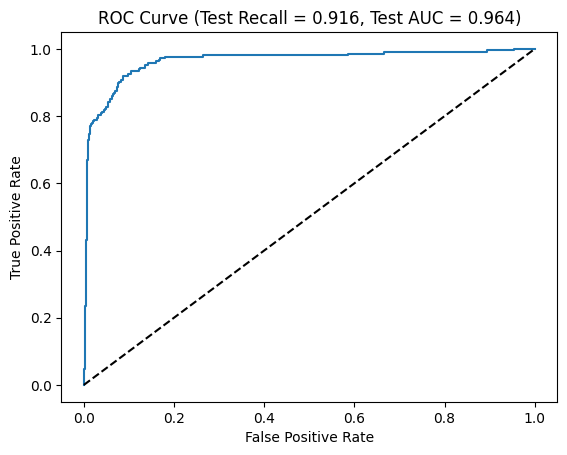

Optimal threshold: 0.307
Final test recall at optimal threshold: 0.916
Final test AUC: 0.964


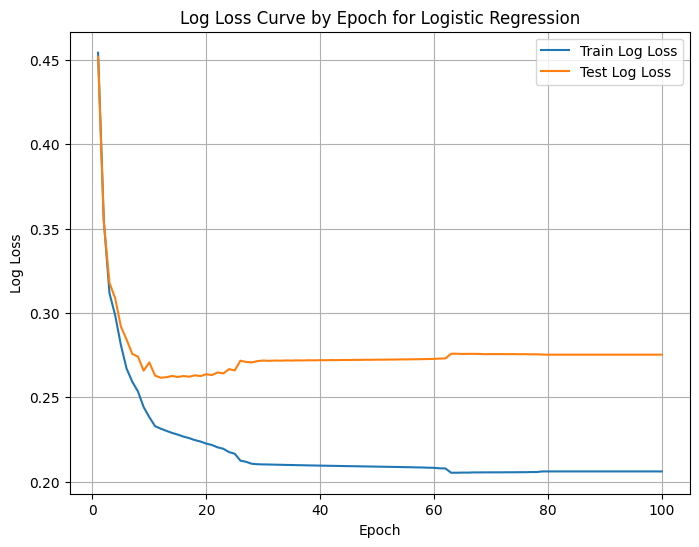

In [16]:
from sklearn.metrics import roc_curve, recall_score, roc_auc_score, log_loss
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LogisticRegression
import numpy as np

features = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
regular_interactions = [['feature_1', 'feature_2'], ['feature_2', 'feature_3'], ['feature_2', 'feature_4'], 
                       ['feature_1', 'feature_3'], ['feature_3', 'feature_4']]

X_train = train[features]
X_test = test[features]
y_train = train['y']
y_test = test['y']

X_train_final = np.hstack([
    X_train,
    *[(train[interaction[0]] * train[interaction[1]]).values.reshape(-1, 1) for interaction in regular_interactions]
])

X_test_final = np.hstack([
    X_test,
    *[(test[interaction[0]] * test[interaction[1]]).values.reshape(-1, 1) for interaction in regular_interactions]
])
model = LogisticRegression(max_iter=1, warm_start=True)

train_losses = []
test_losses = []
n_epochs = 100

for epoch in range(n_epochs):
    model.fit(X_train_final, y_train)
    train_pred_proba = model.predict_proba(X_train_final)[:, 1]
    test_pred_proba = model.predict_proba(X_test_final)[:, 1]
    
    train_loss = log_loss(y_train, train_pred_proba)
    test_loss = log_loss(y_test, test_pred_proba)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)

feature_names = features.copy()
feature_names.extend([f"{interaction[0]}_x_{interaction[1]}" for interaction in regular_interactions])

coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_[0]
})
print("\nModel Coefficients:")
print(coefficients)

fpr, tpr, thresholds = roc_curve(y_test, test_pred_proba)
optimal_threshold = thresholds[np.argmin(np.abs(fpr - (1-tpr)))]
y_pred = (test_pred_proba >= optimal_threshold).astype(int)

final_recall = recall_score(y_test, y_pred)
final_auc = roc_auc_score(y_test, test_pred_proba)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Test Recall = {final_recall:.3f}, Test AUC = {final_auc:.3f})')
plt.show()

print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"Final test recall at optimal threshold: {final_recall:.3f}")
print(f"Final test AUC: {final_auc:.3f}")

plt.figure(figsize=(8, 6))
epochs = range(1, n_epochs + 1)
plt.plot(epochs, train_losses, label='Train Log Loss')
plt.plot(epochs, test_losses, label='Test Log Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Log Loss Curve by Epoch for Logistic Regression')
plt.grid(True)
plt.legend()
plt.show()

# CODE CHUNK ZERO


Model Coefficients:
                            Feature  Coefficient
0                         feature_1    -5.549201
1                         feature_2    -3.146625
2                         feature_3    -1.989781
3                         feature_4     0.765221
4    feature_1_x_feature_3_spline_0    -0.000024
5    feature_1_x_feature_3_spline_1    -0.000156
6    feature_1_x_feature_3_spline_2    -0.000733
7    feature_1_x_feature_3_spline_3    -0.001180
8    feature_1_x_feature_3_spline_4    -0.001536
9    feature_1_x_feature_3_spline_5    -0.001994
10   feature_1_x_feature_3_spline_6     0.000047
11   feature_1_x_feature_3_spline_7     0.000891
12   feature_1_x_feature_3_spline_8     0.061295
13   feature_1_x_feature_3_spline_9    -0.067174
14  feature_1_x_feature_3_spline_10    -0.846136
15  feature_1_x_feature_3_spline_11    -0.222405
16  feature_1_x_feature_3_spline_12    -0.097994
17  feature_1_x_feature_3_spline_13    -0.183762
18  feature_1_x_feature_3_spline_14     0.000417

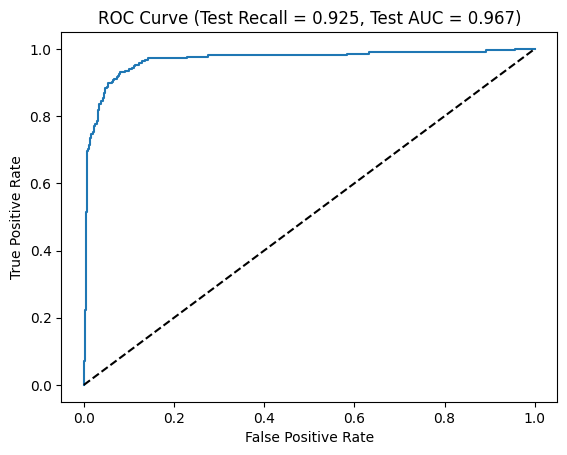

Optimal threshold: 0.314
Final test recall at optimal threshold: 0.925
Final test AUC: 0.967


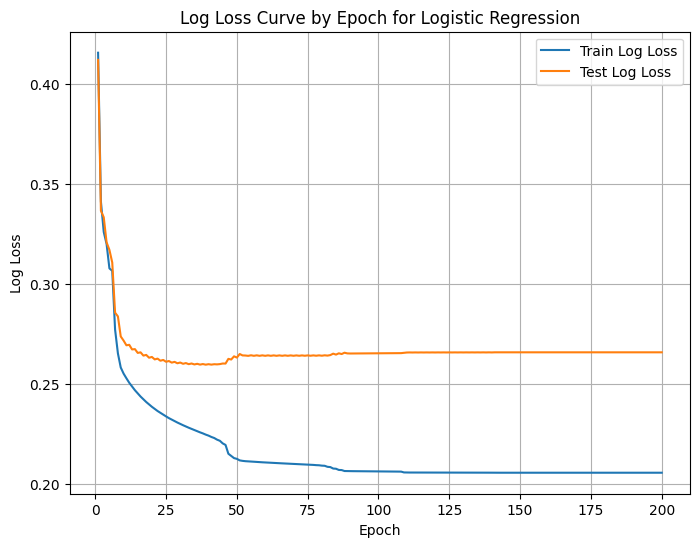

In [23]:
from sklearn.metrics import roc_curve, recall_score, roc_auc_score
from sklearn.preprocessing import SplineTransformer
import numpy as np

def create_split_splines(data_train, data_test, interaction_term, n_knots=10, degree=3):
    interaction_train = data_train[interaction_term[0]] * data_train[interaction_term[1]]
    interaction_test = data_test[interaction_term[0]] * data_test[interaction_term[1]]
    
    spline_left = SplineTransformer(n_knots=n_knots, degree=degree)
    spline_right = SplineTransformer(n_knots=n_knots, degree=degree)
    
    left_mask_train = interaction_train <= 0
    right_mask_train = ~left_mask_train
    left_mask_test = interaction_test <= 0 
    right_mask_test = ~left_mask_test
    
    X_train_spline = np.zeros((len(data_train), 2 * n_knots + 2 * degree - 2))
    X_test_spline = np.zeros((len(data_test), 2 * n_knots + 2 * degree - 2))
    
    n_features = n_knots + degree - 1
    X_train_spline[left_mask_train, :n_features] = spline_left.fit_transform(interaction_train[left_mask_train].values.reshape(-1, 1))
    X_train_spline[right_mask_train, n_features:] = spline_right.fit_transform(interaction_train[right_mask_train].values.reshape(-1, 1))
    X_test_spline[left_mask_test, :n_features] = spline_left.transform(interaction_test[left_mask_test].values.reshape(-1, 1))
    X_test_spline[right_mask_test, n_features:] = spline_right.transform(interaction_test[right_mask_test].values.reshape(-1, 1))
    
    return X_train_spline, X_test_spline, spline_left, spline_right

features = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
splined_interactions = [['feature_1', 'feature_3'], ['feature_3', 'feature_4']]
regular_interactions = [['feature_1', 'feature_2'], ['feature_2', 'feature_3'], ['feature_2', 'feature_4']]

n_knots = 10
degree = 3

X_train = train[features]
X_test = test[features]
y_train = train['y']
y_test = test['y']

X_train_splines = [X_train]
X_test_splines = [X_test]
spline_transformers = {}

for i, interaction in enumerate(splined_interactions):
    X_train_spline, X_test_spline, spline_left, spline_right = create_split_splines(train, test, interaction)
    X_train_splines.append(X_train_spline)
    X_test_splines.append(X_test_spline)
    spline_transformers[i] = (spline_left, spline_right)

for interaction in regular_interactions:
    X_train_splines.append((train[interaction[0]] * train[interaction[1]]).values.reshape(-1, 1))
    X_test_splines.append((test[interaction[0]] * test[interaction[1]]).values.reshape(-1, 1))

X_train_final = np.hstack(X_train_splines)
X_test_final = np.hstack(X_test_splines)

model = LogisticRegression(max_iter=1, warm_start=True, fit_intercept=True)

train_losses = []
test_losses = []
n_epochs = 200

for epoch in range(n_epochs):
    model.fit(X_train_final, y_train)
    train_pred_proba = model.predict_proba(X_train_final)[:, 1]
    test_pred_proba = model.predict_proba(X_test_final)[:, 1]
    
    train_loss = log_loss(y_train, train_pred_proba)
    test_loss = log_loss(y_test, test_pred_proba)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)

coefficients = pd.DataFrame(
    {'Feature': features + 
     [f"{interaction[0]}_x_{interaction[1]}_spline_{i}" for interaction in splined_interactions for i in range(2 * n_knots + 2 * degree - 2)] +
     [f"{interaction[0]}_x_{interaction[1]}" for interaction in regular_interactions],
     'Coefficient': model.coef_[0]
    })
print("\nModel Coefficients:")
print(coefficients)
print(f"\nIntercept: {model.intercept_[0]}")

fpr, tpr, thresholds = roc_curve(y_test, test_pred_proba)
optimal_threshold = thresholds[np.argmin(np.abs(fpr - (1-tpr)))]
y_pred = (test_pred_proba >= optimal_threshold).astype(int)

final_recall = recall_score(y_test, y_pred)
final_auc = roc_auc_score(y_test, test_pred_proba)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Test Recall = {final_recall:.3f}, Test AUC = {final_auc:.3f})')
plt.show()

print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"Final test recall at optimal threshold: {final_recall:.3f}")
print(f"Final test AUC: {final_auc:.3f}")

plt.figure(figsize=(8, 6))
epochs = range(1, n_epochs + 1)
plt.plot(epochs, train_losses, label='Train Log Loss')
plt.plot(epochs, test_losses, label='Test Log Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Log Loss Curve by Epoch for Logistic Regression')
plt.grid(True)
plt.legend()
plt.show()

Dropdown(description='Left Plot:', options=('Predicted & Observed',), value='Predicted & Observed')

Dropdown(description='Right Plot:', options=('Predicted & Observed',), value='Predicted & Observed')

Dropdown(description='Feature:', options=('feature_1', 'feature_2', 'feature_3', 'feature_4'), value='feature_…

IntSlider(value=50, description='Bins:', min=10, step=5)

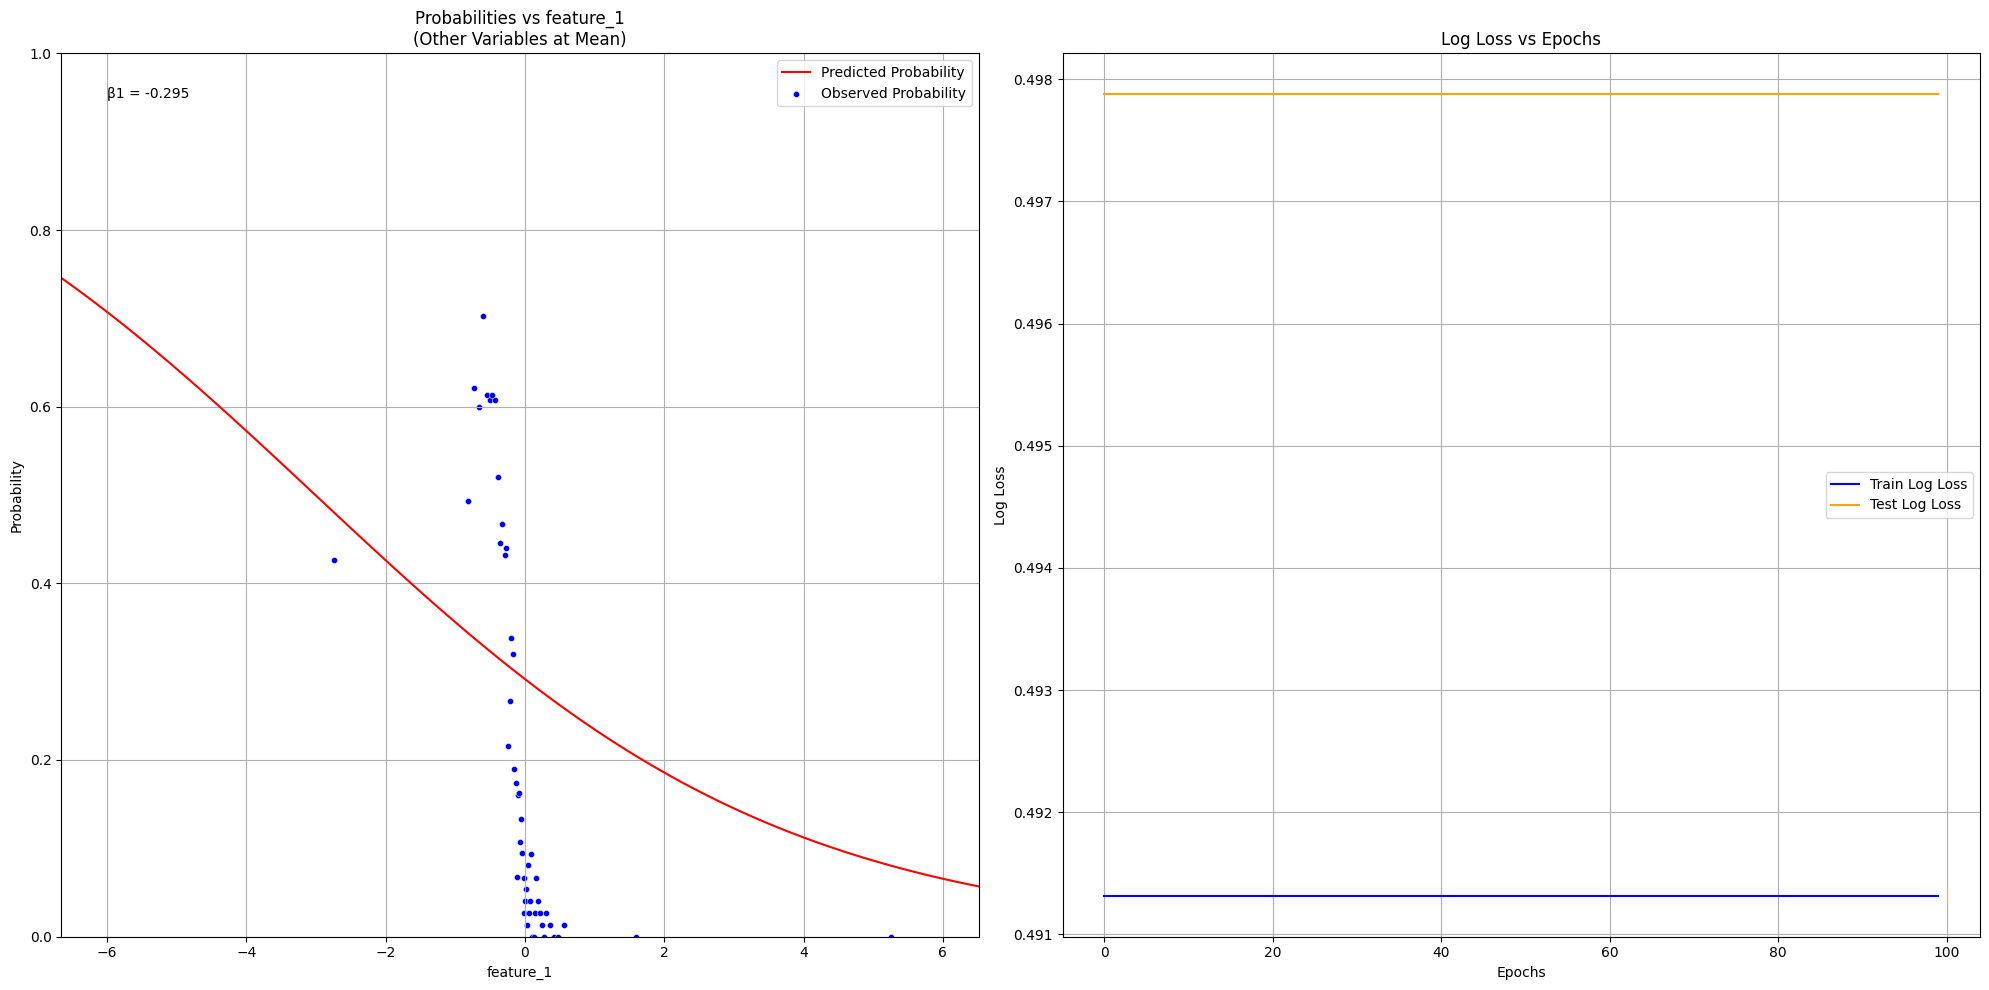

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

X = train[['feature_1', 'feature_2', 'feature_3', 'feature_4']]
y = train['y']

n_epochs = 100
train_losses = []
test_losses = []

lr_model = LogisticRegression(random_state=42, max_iter=1)

for epoch in range(n_epochs):
    lr_model.fit(X, y)
    train_pred = lr_model.predict_proba(X)
    train_loss = log_loss(y, train_pred)
    train_losses.append(train_loss)
    
    test_pred = lr_model.predict_proba(X_test[['feature_1', 'feature_2', 'feature_3', 'feature_4']])
    test_loss = log_loss(y_test, test_pred)
    test_losses.append(test_loss)

mean_values = X.mean()
coefficients = lr_model.coef_[0]

def create_plots(plot_type_left, plot_type_right, feature, n_bins):
    plt.figure(figsize=(20, 10))
    
    x_range = np.linspace(X[feature].min(), X[feature].max(), 100)
    pred_data = np.tile(mean_values, (100, 1))
    pred_data = pd.DataFrame(pred_data, columns=X.columns)
    pred_data[feature] = x_range
    y_pred = lr_model.predict_proba(pred_data)[:, 1]
    
    bins = pd.qcut(X[feature], q=n_bins, duplicates='drop')
    bin_means = X.groupby(bins)[feature].mean()
    bin_probs = train.groupby(bins)['y'].mean()
    
    plt.subplot(1, 2, 1)
    plt.plot(x_range, y_pred, label='Predicted Probability', color='red')
    sns.scatterplot(x=bin_means, y=bin_probs, color='blue', s=20, label='Observed Probability')
    plt.text(0.05, 0.95, f'β{list(X.columns).index(feature)+1} = {coefficients[list(X.columns).index(feature)]:.3f}', transform=plt.gca().transAxes)
    plt.title(f'Probabilities vs {feature}\n(Other Variables at Mean)')
    plt.ylabel('Probability')
    plt.xlabel(feature)
    plt.ylim(0, 1)
    plt.xlim(X[feature].min(), X[feature].max())
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(range(n_epochs), train_losses, label='Train Log Loss', color='blue')
    plt.plot(range(n_epochs), test_losses, label='Test Log Loss', color='orange')
    plt.title('Log Loss vs Epochs')
    plt.ylabel('Log Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_type_left = widgets.Dropdown(
    options=['Predicted & Observed'],
    description='Left Plot:',
    value='Predicted & Observed'
)

plot_type_right = widgets.Dropdown(
    options=['Predicted & Observed'],
    description='Right Plot:',
    value='Predicted & Observed'
)

feature_selector = widgets.Dropdown(
    options=['feature_1', 'feature_2', 'feature_3', 'feature_4'],
    description='Feature:',
    value='feature_1'
)

bin_slider = widgets.IntSlider(
    value=50,
    min=10,
    max=100,
    step=5,
    description='Bins:'
)

def on_change(change):
    clear_output(wait=True)
    display(plot_type_left)
    display(plot_type_right)
    display(feature_selector)
    display(bin_slider)
    create_plots(plot_type_left.value, plot_type_right.value, feature_selector.value, bin_slider.value)

plot_type_left.observe(on_change, names='value')
plot_type_right.observe(on_change, names='value')
feature_selector.observe(on_change, names='value')
bin_slider.observe(on_change, names='value')

display(plot_type_left)
display(plot_type_right)
display(feature_selector)
display(bin_slider)
create_plots(plot_type_left.value, plot_type_right.value, feature_selector.value, bin_slider.value)

Dropdown(description='Feature:', options=('feature_1', 'feature_2', 'feature_3', 'feature_4'), value='feature_…

IntSlider(value=100, description='Bins:', min=10, step=5)

FloatSlider(value=-3.3570559813867087, description='Knot 1:', max=8.513493692391563, min=-8.657055981386709)

FloatSlider(value=-0.057055981386708865, description='Knot 2:', max=8.513493692391563, min=-8.657055981386709)

FloatSlider(value=3.242944018613292, description='Knot 3:', max=8.513493692391563, min=-8.657055981386709)

KeyError: 0

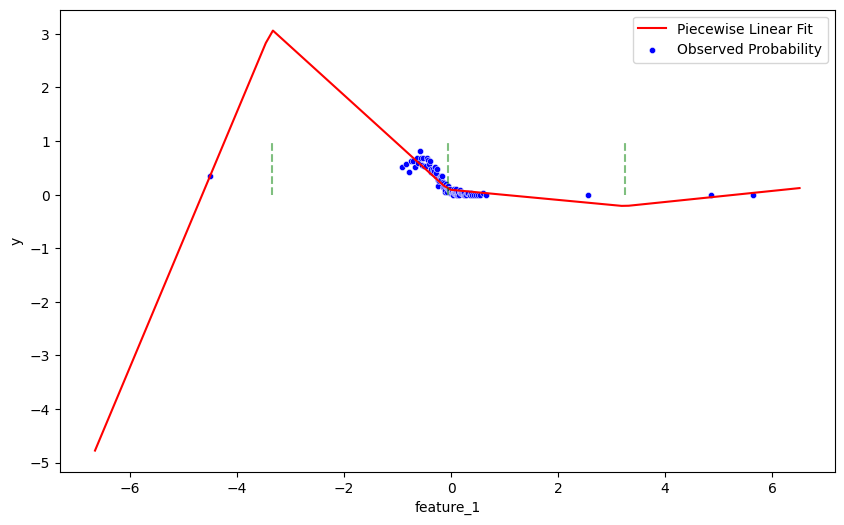

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.interpolate import LSQUnivariateSpline

X = train[['feature_1', 'feature_2', 'feature_3', 'feature_4']]
y = train['y']

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X, y)

mean_values = X.mean()
coefficients = lr_model.coef_[0]

def create_plots(feature, n_bins, knot1_val, knot2_val, knot3_val):
    plt.figure(figsize=(10, 6))
    
    bins = pd.qcut(X[feature], q=n_bins, duplicates='drop')
    bin_means = X.groupby(bins)[feature].mean()
    bin_probs = train.groupby(bins)['y'].mean()
    
    x_range = np.linspace(X[feature].min(), X[feature].max(), 100)
    knots = np.array([knot1_val, knot2_val, knot3_val])
    
    spline = LSQUnivariateSpline(bin_means, bin_probs, knots, k=1)
    y_pred = spline(x_range)
    
    plt.plot(x_range, y_pred, label='Piecewise Linear Fit', color='red')
    sns.scatterplot(x=bin_means, y=bin_probs, color='blue', s=20, label='Observed Probability')
    plt.vlines(knots, 0, 1, colors='green', linestyles='dashed', alpha=0.5, label='Knots')
    plt.text(0.05, 0.95, f'β{list(X.columns).index(feature)+1} = {coefficients[list(X.columns).index(feature)]:.3f}', transform=plt.gca().transAxes)
    plt.title(f'Probabilities vs {feature}\n(Other Variables at Mean)')
    plt.ylabel('Probability')
    plt.xlabel(feature)
    plt.ylim(0, 1)
    plt.xlim(X[feature].min(), X[feature].max())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    print(f"Knot locations: {knots}")
    plt.show()

feature_selector = widgets.Dropdown(
    options=['feature_1', 'feature_2', 'feature_3', 'feature_4'],
    description='Feature:',
    value='feature_1'
)

bin_slider = widgets.IntSlider(
    value=100,
    min=10,
    max=100,
    step=5,
    description='Bins:'
)

knot1 = widgets.FloatSlider(
    value=X[feature_selector.value].min() + (X[feature_selector.value].max()-X[feature_selector.value].min())*0.25,
    min=X[feature_selector.value].min() - 2,
    max=X[feature_selector.value].max() + 2,
    description='Knot 1:'
)

knot2 = widgets.FloatSlider(
    value=X[feature_selector.value].min() + (X[feature_selector.value].max()-X[feature_selector.value].min())*0.5,
    min=X[feature_selector.value].min() - 2,
    max=X[feature_selector.value].max() + 2,
    description='Knot 2:'
)

knot3 = widgets.FloatSlider(
    value=X[feature_selector.value].min() + (X[feature_selector.value].max()-X[feature_selector.value].min())*0.75,
    min=X[feature_selector.value].min() - 2,
    max=X[feature_selector.value].max() + 2,
    description='Knot 3:'
)

def on_change(change):
    clear_output(wait=True)
    display(feature_selector)
    display(bin_slider)
    display(knot1)
    display(knot2)
    display(knot3)
    create_plots(feature_selector.value, bin_slider.value, knot1.value, knot2.value, knot3.value)

feature_selector.observe(on_change, names='value')
bin_slider.observe(on_change, names='value')
knot1.observe(on_change, names='value')
knot2.observe(on_change, names='value')
knot3.observe(on_change, names='value')

display(feature_selector)
display(bin_slider)
display(knot1)
display(knot2)
display(knot3)
create_plots(feature_selector.value, bin_slider.value, knot1.value, knot2.value, knot3.value)

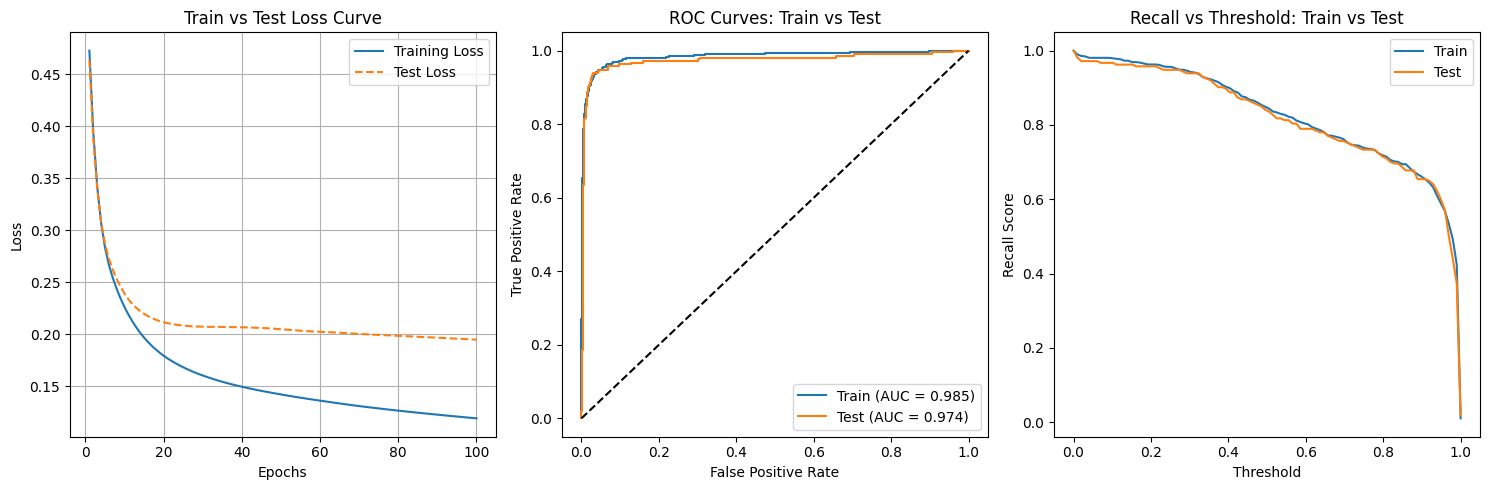

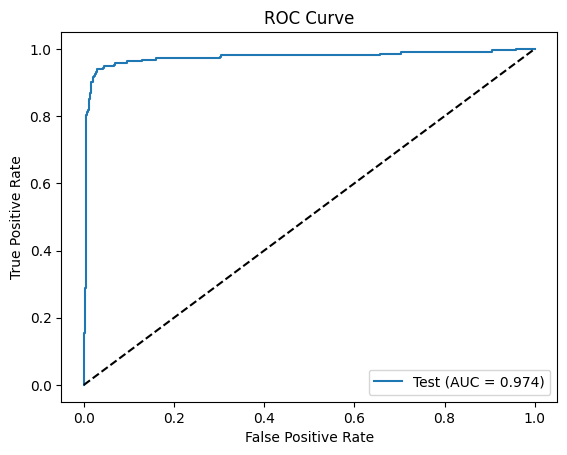

Train AUC: 0.985
Test AUC: 0.974
Optimal threshold: 0.282
Recall at optimal threshold: 0.949


In [14]:
from sklearn.metrics import roc_curve, recall_score, roc_auc_score, log_loss
from sklearn.preprocessing import SplineTransformer
from sklearn.neural_network import MLPClassifier
import numpy as np

def create_split_splines(data_train, data_test, interaction_term, n_knots=10, degree=3):
    interaction_train = data_train[interaction_term[0]] * data_train[interaction_term[1]]
    interaction_test = data_test[interaction_term[0]] * data_test[interaction_term[1]]
    
    spline_left = SplineTransformer(n_knots=n_knots, degree=degree)
    spline_right = SplineTransformer(n_knots=n_knots, degree=degree)
    
    left_mask_train = interaction_train <= 0
    right_mask_train = ~left_mask_train
    left_mask_test = interaction_test <= 0 
    right_mask_test = ~left_mask_test
    
    X_train_spline = np.zeros((len(data_train), 2 * n_knots + 2 * degree - 2))
    X_test_spline = np.zeros((len(data_test), 2 * n_knots + 2 * degree - 2))
    
    n_features = n_knots + degree - 1
    X_train_spline[left_mask_train, :n_features] = spline_left.fit_transform(interaction_train[left_mask_train].values.reshape(-1, 1))
    X_train_spline[right_mask_train, n_features:] = spline_right.fit_transform(interaction_train[right_mask_train].values.reshape(-1, 1))
    X_test_spline[left_mask_test, :n_features] = spline_left.transform(interaction_test[left_mask_test].values.reshape(-1, 1))
    X_test_spline[right_mask_test, n_features:] = spline_right.transform(interaction_test[right_mask_test].values.reshape(-1, 1))
    
    return X_train_spline, X_test_spline, spline_left, spline_right

features = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
splined_interactions = [['feature_1', 'feature_3'], ['feature_3', 'feature_4']]
regular_interactions = [['feature_1', 'feature_2'], ['feature_2', 'feature_3'], ['feature_2', 'feature_4']]

n_knots = 10
degree = 3

X_train = train[features]
X_test = test[features]
y_train = train['y']
y_test = test['y']

X_train_splines = [X_train]
X_test_splines = [X_test]
spline_transformers = {}

for i, interaction in enumerate(splined_interactions):
    X_train_spline, X_test_spline, spline_left, spline_right = create_split_splines(train, test, interaction)
    X_train_splines.append(X_train_spline)
    X_test_splines.append(X_test_spline)
    spline_transformers[i] = (spline_left, spline_right)

for interaction in regular_interactions:
    X_train_splines.append((train[interaction[0]] * train[interaction[1]]).values.reshape(-1, 1))
    X_test_splines.append((test[interaction[0]] * test[interaction[1]]).values.reshape(-1, 1))

X_train_final = np.hstack(X_train_splines)
X_test_final = np.hstack(X_test_splines)

model = MLPClassifier(hidden_layer_sizes=(128, 128), activation='relu', solver='sgd', learning_rate_init=0.01, random_state=42, warm_start=True)

train_losses = []
test_losses = []
max_epochs = 100

for epoch in range(1, max_epochs + 1):
    model.max_iter = epoch
    model.partial_fit(X_train_final, y_train, classes=np.unique(y_train))
    
    train_pred_proba = model.predict_proba(X_train_final)
    test_pred_proba = model.predict_proba(X_test_final)
    
    train_losses.append(log_loss(y_train, train_pred_proba))
    test_losses.append(log_loss(y_test, test_pred_proba))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(range(1, max_epochs + 1), train_losses, label="Training Loss")
ax1.plot(range(1, max_epochs + 1), test_losses, label="Test Loss", linestyle="--")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Train vs Test Loss Curve")
ax1.legend()
ax1.grid(True)

fpr_train, tpr_train, _ = roc_curve(y_train, train_pred_proba[:, 1])
fpr_test, tpr_test, thresholds = roc_curve(y_test, test_pred_proba[:, 1])

train_auc = roc_auc_score(y_train, train_pred_proba[:, 1])
test_auc = roc_auc_score(y_test, test_pred_proba[:, 1])

ax2.plot(fpr_train, tpr_train, label=f'Train (AUC = {train_auc:.3f})')
ax2.plot(fpr_test, tpr_test, label=f'Test (AUC = {test_auc:.3f})')
ax2.plot([0, 1], [0, 1], 'k--')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves: Train vs Test')
ax2.legend()

train_scores = []
test_scores = []
thresholds_range = np.linspace(0, 1, 100)

for threshold in thresholds_range:
    train_pred = (train_pred_proba[:, 1] >= threshold).astype(int)
    test_pred = (test_pred_proba[:, 1] >= threshold).astype(int)
    train_scores.append(recall_score(y_train, train_pred))
    test_scores.append(recall_score(y_test, test_pred))

ax3.plot(thresholds_range, train_scores, label='Train')
ax3.plot(thresholds_range, test_scores, label='Test')
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Recall Score')
ax3.set_title('Recall vs Threshold: Train vs Test')
ax3.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(6.4, 4.8))
plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

fnr = 1 - tpr_test
optimal_idx = np.argmin(np.abs(fpr_test - fnr))
optimal_threshold = thresholds[optimal_idx]

y_pred = (test_pred_proba[:, 1] >= optimal_threshold).astype(int)
recall = recall_score(y_test, y_pred)

print(f"Train AUC: {train_auc:.3f}")
print(f"Test AUC: {test_auc:.3f}")
print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"Recall at optimal threshold: {recall:.3f}")